## Assignment 2
## Forecasting the Wind Power Production in Orkney

### Imports

In [1]:
import mlflow
import mlflow.pyfunc
import math 
import pandas as pd
import numpy as np
import subprocess
import os 

from mlflow import MlflowClient
from influxdb import InfluxDBClient
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Getting the data with InfluxDB

The data is stored in an [InfluxDB](https://www.influxdata.com/), which is a non-relational time-series database. InfluxDB can be queried using [InfluxQL](https://docs.influxdata.com/influxdb/v1.8/query_language/spec/), a "SQL-like" query language for time-series data.

In [2]:
# Set the needed parameters to connect to the database
settings = {
    'host': 'influxus.itu.dk',
    'port': 8086,
    'username': 'lsda',
    'password': 'icanonlyread'
    }

# Create an InfluxDB Client instance and select the orkney database
client_query = InfluxDBClient(host=settings['host'], port=settings['port'], username=settings['username'], password=settings['password'])
client_query.switch_database('orkney')

We can use an auxiliary function to convert the resulting set from the query into a Pandas Dataframe, making it easier to work with.

In [3]:
# Function to tranform the InfluxDB resulting set into a pandas Dataframe
def set_to_dataframe(resulting_set):
    
    values = resulting_set.raw["series"][0]["values"]
    columns = resulting_set.raw["series"][0]["columns"]
    df = pd.DataFrame(values, columns=columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime-index

    return df

Now we are ready to retrieve the data.<br>
We will take 180 days from the previous month, we will use the last month to validate our model after.

In [4]:
days = 180 # You can change this to get any other range of days
interval = 30 #  We will use this range to validate our models later

power_set = client_query.query(
    "SELECT time, Total FROM Generation where time > now()-"+str(days+interval)+"d and time <= now()-"+str(interval)+"d"
    ) 
# Lead time is the difference between the source time and the target time
wind_set  = client_query.query(
    "SELECT time, Direction, Speed FROM MetForecasts where time > now()-"+str(days+interval)+"d and time <= now()-"+str(interval)+"d and Lead_hours = '1'"
    )

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)

Let's take a look at the resulting dataframes:

In [5]:
print(power_df)
print(wind_df)

                               Total
time                                
2023-05-01 12:24:00+00:00   9.380242
2023-05-01 12:25:00+00:00  10.196267
2023-05-01 12:26:00+00:00   9.151343
2023-05-01 12:27:00+00:00   8.903617
2023-05-01 12:28:00+00:00   9.116364
...                              ...
2023-10-28 12:19:00+00:00  21.978362
2023-10-28 12:20:00+00:00  21.984833
2023-10-28 12:21:00+00:00  21.806752
2023-10-28 12:22:00+00:00  22.521688
2023-10-28 12:23:00+00:00  22.678941

[252504 rows x 1 columns]
                          Direction     Speed
time                                         
2023-05-01 15:00:00+00:00        NW   7.15264
2023-05-01 18:00:00+00:00       NNW   8.94080
2023-05-01 21:00:00+00:00       NNW   7.15264
2023-05-02 00:00:00+00:00       NNW   8.94080
2023-05-02 03:00:00+00:00         N   5.81152
...                             ...       ...
2023-10-28 00:00:00+00:00         E   9.83488
2023-10-28 03:00:00+00:00         E   8.94080
2023-10-28 06:00:00+00:00       

In addition to making a simple join we will also try to make one where we will consider not the point measurement of energy, but the average over the time interval of the weather forecast (3 hours)

In [6]:
# Group 3H by doing a mean on the Total column
resampled_df = power_df.resample('3H').mean()
print(resampled_df)

                               Total
time                                
2023-05-01 12:00:00+00:00  10.772803
2023-05-01 15:00:00+00:00  16.469399
2023-05-01 18:00:00+00:00  13.010661
2023-05-01 21:00:00+00:00   9.324023
2023-05-02 00:00:00+00:00   5.669893
...                              ...
2023-10-28 00:00:00+00:00  17.894604
2023-10-28 03:00:00+00:00  16.973218
2023-10-28 06:00:00+00:00  18.823656
2023-10-28 09:00:00+00:00  20.757133
2023-10-28 12:00:00+00:00  22.142661

[1441 rows x 1 columns]


### Merging the data sources

In [7]:
# Mean join
joined_mean_df = resampled_df.join(wind_df, how="inner")

# Simple join (take only the value at each correct time)
joined_df = power_df.join(wind_df, how="inner")

print(joined_mean_df)
print(joined_df)
# you can see a small difference in the total column

                               Total Direction     Speed
time                                                    
2023-05-01 15:00:00+00:00  16.469399        NW   7.15264
2023-05-01 18:00:00+00:00  13.010661       NNW   8.94080
2023-05-01 21:00:00+00:00   9.324023       NNW   7.15264
2023-05-02 00:00:00+00:00   5.669893       NNW   8.94080
2023-05-02 03:00:00+00:00   3.497530         N   5.81152
...                              ...       ...       ...
2023-10-28 00:00:00+00:00  17.894604         E   9.83488
2023-10-28 03:00:00+00:00  16.973218         E   8.94080
2023-10-28 06:00:00+00:00  18.823656         E   9.83488
2023-10-28 09:00:00+00:00  20.757133       ESE  11.17600
2023-10-28 12:00:00+00:00  22.142661       ESE  12.96416

[1397 rows x 3 columns]
                               Total Direction     Speed
time                                                    
2023-05-01 15:00:00+00:00  12.955541        NW   7.15264
2023-05-01 18:00:00+00:00  14.744819       NNW   8.94080
2023-0

### Understanding the data

It can be also useful to plot our datasets to see what relationships they might hold.<br>

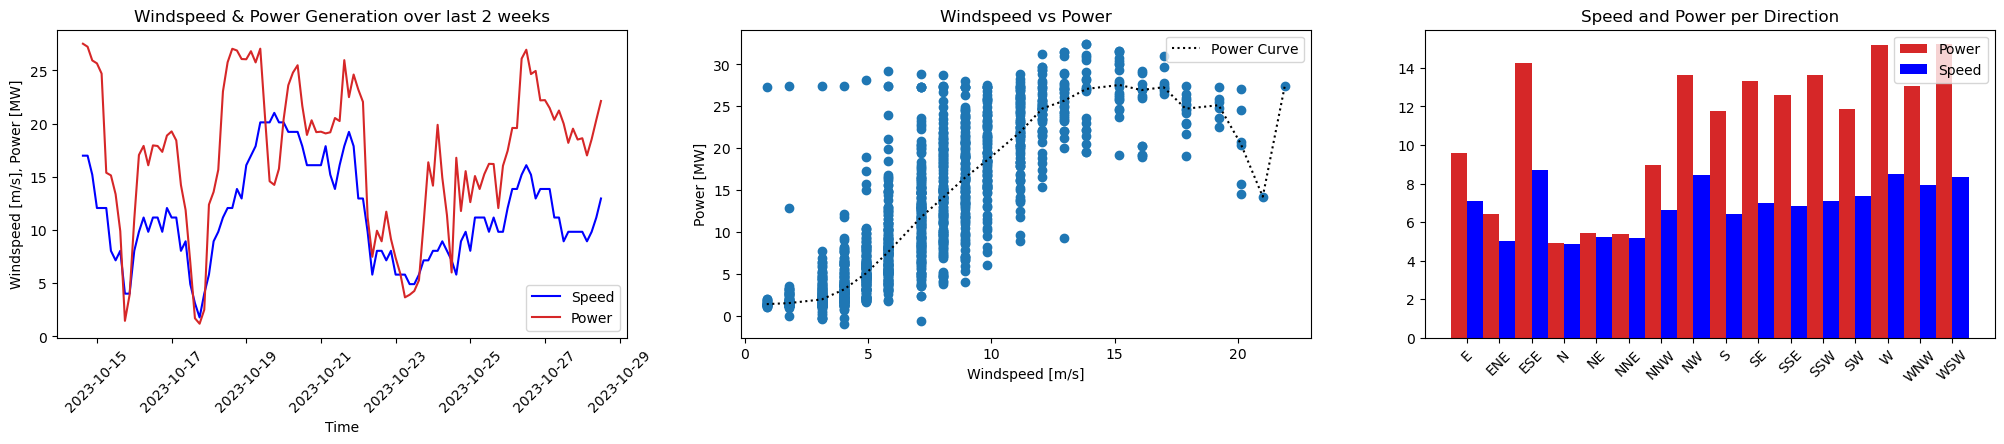

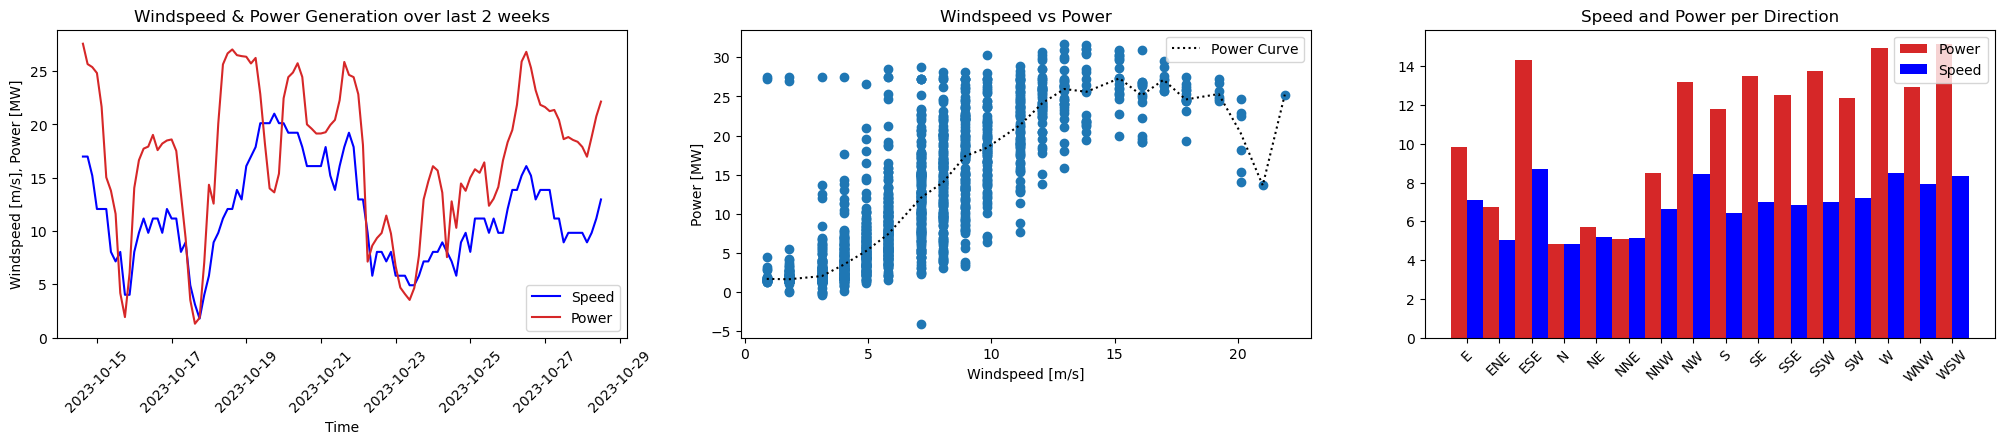

In [8]:
def understanding_data(dataframe):    
    fig, ax = plt.subplots(1,3, figsize=(25,4))

    # Speed and Power for the last 7 days
    ax[0].plot(dataframe["Speed"].tail(int(14*24/3)), label="Speed", color="blue") 
    ax[0].plot(dataframe["Total"].tail(int(14*24/3)), label="Power", color="tab:red") 
    ax[0].set_title("Windspeed & Power Generation over last 2 weeks")
    ax[0].set_xlabel("Time")
    ax[0].tick_params(axis='x', labelrotation = 45)
    ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
    ax[0].legend()

    # Speed vs Total (Power Curve nature)
    ax[1].scatter(dataframe["Speed"], dataframe["Total"])
    power_curve = dataframe.groupby("Speed")["Total"].median()
    ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
    ax[1].legend()
    ax[1].set_title("Windspeed vs Power")
    ax[1].set_ylabel("Power [MW]")
    ax[1].set_xlabel("Windspeed [m/s]")

    # Speed and Power per Wind Direction
    power_grouped_by_direction = dataframe.groupby("Direction")["Total"].mean().reset_index()
    wind_grouped_by_direction = dataframe.groupby("Direction")["Speed"].mean().reset_index()
    bar_width = 0.5
    x = np.arange(len(wind_grouped_by_direction.index))

    ax[2].bar(x - bar_width/2, power_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
    ax[2].bar(x + bar_width/2, wind_grouped_by_direction.Speed, width=0.5, label="Speed", color="blue")
    ax[2].legend()
    ax[2].set_xticks(x)
    ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
    ax[2].tick_params(axis='x', labelrotation = 45)
    ax[2].set_title("Speed and Power per Direction")

understanding_data(joined_df)
understanding_data(joined_mean_df)

We can see as the second one as a smoother function for the Power Generation over different days but for the rest they are quite similar.<br>
To better see how wind direction influences the data, we are going to analyze at the same speed how the power produced changes according to direction

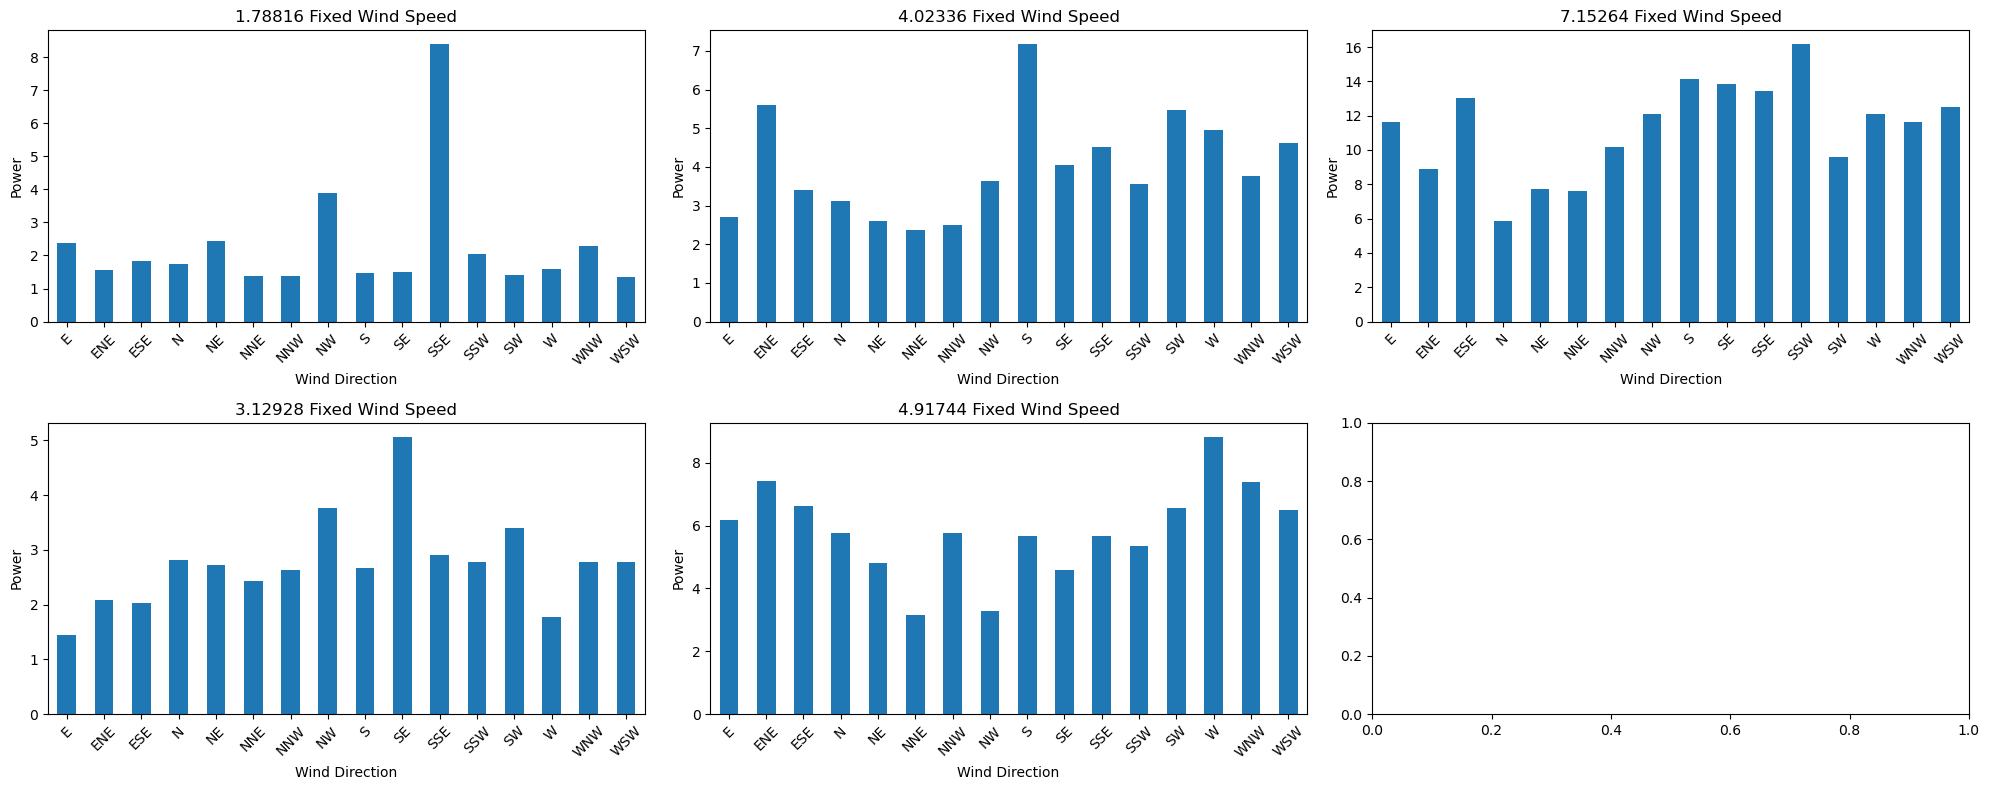

In [9]:

def plot_power_by_direction(df):
    # Counts the number of unique directions for each speed
    wind_speed_counts = df.groupby('Speed')['Direction'].nunique()

    # We take only the velocities that appear in all 16 directions
    array_of_speeds = wind_speed_counts[wind_speed_counts == 16].index.tolist()

    # We create a subplot to group plots together
    num_subplots = len(array_of_speeds)
    num_rows = 2
    fig, axes = plt.subplots(num_rows, math.ceil(num_subplots/num_rows), figsize=(20,8))

    x = 0
    y = 0

    for i, selected_value in enumerate(array_of_speeds):
        # Filters data by selected wind speed
        filtered_data = df[df['Speed'] == selected_value]

        # Group the data by direction and calculate the average power generated
        grouped_data = filtered_data.groupby('Direction')['Total'].mean()
        
        if i != 0 and i % num_rows == 0:
            y = y + 1
            x = 0

        ax = axes[x,y]
    
        # Plot the data
        grouped_data.plot(kind='bar', ax=ax, rot=0)
        ax.set_xlabel('Wind Direction')
        ax.set_ylabel('Power')
        
        ax.set_title(f'{selected_value} Fixed Wind Speed')
        ax.tick_params(axis='x', labelrotation=45)
        x = x + 1

    plt.tight_layout()
    plt.show()

plot_power_by_direction(joined_df)


### Identificate our models
We will first do a local training and after, by changing the parameters we will evaluate through MLFlow.<br>
We will use:
1. PolynomialRegression without Direction
2. PolynomialRegression with Direction
3. RandomForestRegressor
4. Multi-layer Perceptron regressor.

In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(3)),  # We will change this value on MLFlow
    ('regressor', LinearRegression())
])

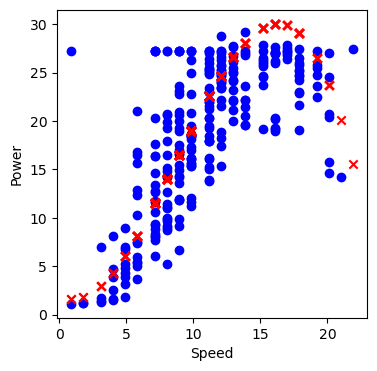

mae=4.01596489620563, mse=28.16413307488399, rmse=5.306989078082221, r2=0.5038242630478378


In [11]:
# Retrieve train and test data
X = joined_df["Speed"].values.reshape(-1,1)
y = joined_df["Total"].values.reshape(-1,1)

# Split the data so we can test how well our model performs in unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate error metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Show graph
fig = plt.figure(figsize=(4,4))
plt.scatter(X_test, y_test, color='blue')
plt.scatter(X_test, y_pred, color='red',marker='x')
plt.xlabel('Speed')
plt.ylabel('Power')
plt.show()

print(f"mae={mae}, mse={mse}, rmse={rmse}, r2={r2}")


In [14]:
# Convert direction to degrees
def direction_to_degrees(direction):
    directions = {
        'N': 0,
        'NNE': 22.5,
        'NE': 45,
        'ENE': 67.5,
        'E': 90,
        'ESE': 112.5,
        'SE': 135,
        'SSE': 157.5,
        'S': 180,
        'SSW': 202.5,
        'SW': 225,
        'WSW': 247.5,
        'W': 270,
        'WNW': 292.5,
        'NW': 315,
        'NNW': 337.5,
    }
    return directions.get(direction, np.nan)

joined_df['Direction'] = joined_df['Direction'].apply(direction_to_degrees)
print(joined_df)

                               Total  Direction     Speed
time                                                     
2023-05-01 15:00:00+00:00  12.955541      315.0   7.15264
2023-05-01 18:00:00+00:00  14.744819      337.5   8.94080
2023-05-01 21:00:00+00:00  11.804323      337.5   7.15264
2023-05-02 00:00:00+00:00   5.953503      337.5   8.94080
2023-05-02 03:00:00+00:00   5.063306        0.0   5.81152
...                              ...        ...       ...
2023-10-28 00:00:00+00:00  18.625941       90.0   9.83488
2023-10-28 03:00:00+00:00  17.009806       90.0   8.94080
2023-10-28 06:00:00+00:00  18.532702       90.0   9.83488
2023-10-28 09:00:00+00:00  20.357991      112.5  11.17600
2023-10-28 12:00:00+00:00  22.124880      112.5  12.96416

[1390 rows x 3 columns]


PolynomialRegression: mae=3.9850013297278095, mse=26.661722850348415, rmse=5.163499089798353, r2=0.5302926616447817
RandomForestRegressor: mae=4.344544875878801, mse=32.404029640782184, rmse=5.692453745159655, r2=0.42912877011034944
MLPRegressor: mae=4.958925484997716, mse=45.08642871689677, rmse=6.714642858477044, r2=0.205699251041494


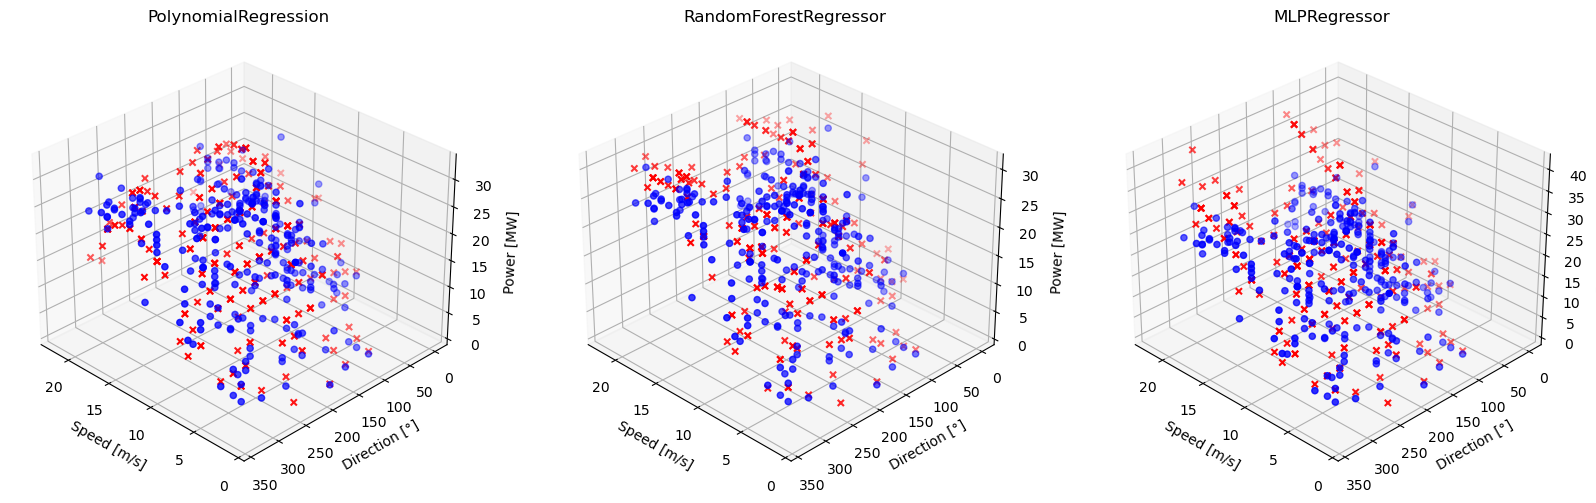

In [15]:
def print_metrics(index,title):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"{title}: mae={mae}, mse={mse}, rmse={rmse}, r2={r2}")
    # plot
    ax[index].view_init(azim=135)
    ax[index].scatter(X_test.Speed, X_test.Direction, y_test, c='b', marker='o')
    ax[index].scatter(X_test.Speed, X_test.Direction, y_pred, c='r', marker='x')
    ax[index].set_zlabel('Power [MW]')
    ax[index].set_xlabel('Speed [m/s]')
    ax[index].set_ylabel('Direction [°]')
    ax[index].set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 8), subplot_kw={'projection': '3d'})
X_1 = joined_df[["Speed","Direction"]]
y_1 = joined_df["Total"]
X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, shuffle=False)

# PolynomialRegression
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print_metrics(0,"PolynomialRegression")

# RandomForestRegressor
params = {
    "n_estimators": 500,
    "max_depth": 100,
    "min_samples_split": 10,
    "min_samples_leaf": 4,
    "bootstrap": True,
    "oob_score": False,
}

rf_model = RandomForestRegressor(**params)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print_metrics(1,"RandomForestRegressor")

# MLPRegressor
params = {
    "hidden_layer_sizes": (100,50),
    "alpha": 0.01,
    "max_iter": 10000, 
    "random_state": 42,
}

mlp = MLPRegressor(**params)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('mlp', mlp)  
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print_metrics(2,"MLPRegressor")

### Tracking our experiments with MLFlow

In [16]:
# Start an MLflow run
mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.autolog()

2023/11/27 13:25:40 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


#### PolyNomial Regression without direction but 2 different dataset

In [17]:
experiment_name = "PolyRegressionStandard" 

mlflow.set_experiment(experiment_name)

def run_experiment(dataframe,type):
    # Retrieve train and test data
    X = dataframe["Speed"].values.reshape(-1,1)
    y = dataframe["Total"].values.reshape(-1,1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    max_poly_degree = 4
    # We will iterate by increasing the degree of the polynomial 
    for degree in range(1, max_poly_degree + 1):
        run_name = type + "_" + str(degree) + "degree"

        with mlflow.start_run(run_name=run_name) as run:
            # Train the model
            pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('poly_features', PolynomialFeatures(degree)),  
            ('regressor', LinearRegression())
            ])

            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)

run_experiment(joined_df,"simple")
run_experiment(joined_mean_df,"mean")

2023/11/27 13:26:02 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/matteo/anaconda3/envs/BDM23_MFlow/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


#### PolyNomial Regression with direction 
We will use for ther further analisis only the first one *joined_df*, see Report.pdf for explanations.

In [18]:
experiment_name = "PolyRegressionDirection" 

mlflow.set_experiment(experiment_name)

def run_experiment_direction(dataframe):
    # Retrive data using also direction
    X_1 = dataframe[["Speed","Direction"]]
    y_1 = dataframe["Total"]

    X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, shuffle=False)
    
    max_poly_degree = 8

    for degree in range(1, max_poly_degree + 1):
        run_name = str(degree) + "degree_direction"

        with mlflow.start_run(run_name=run_name) as run:

            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('poly_features', PolynomialFeatures(degree)),  
                ('regressor', LinearRegression())
            ])

            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)

run_experiment_direction(joined_df)

#### Random Forest Regressor

In [19]:
experiment_name = "RandomForestRegressor" 

mlflow.set_experiment(experiment_name)

def run_experiment_rf(dataframe):
    
    X_1 = dataframe[["Speed","Direction"]]
    y_1 = dataframe["Total"]

    X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, shuffle=False)
    
    n_estimators_values = [100, 500, 1000, 5000]
    max_depth_values = [10, 50, 100, 200]

    for n_estimators in n_estimators_values:
        for max_depth in max_depth_values:

            run_name = str(n_estimators) + "estimators_" + str(max_depth) + "maxdepth"
            with mlflow.start_run(run_name=run_name) as run:
                params = {
                    "n_estimators": n_estimators,
                    "max_depth": max_depth,
                    "min_samples_split": 10,
                    "min_samples_leaf": 4,
                    "bootstrap": True,
                    "oob_score": False,
                }

                rf_model = RandomForestRegressor(**params)
                rf_model.fit(X_train, y_train)
                y_pred = rf_model.predict(X_test)

run_experiment_rf(joined_df)

#### MLPRegressor

In [20]:
experiment_name = "MLPRegressor" 

mlflow.set_experiment(experiment_name)

def run_experiment_mlp(dataframe):
    
    X_1 = dataframe[["Speed","Direction"]]
    y_1 = dataframe["Total"]

    X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, shuffle=False)
    
    hidden_layer_sizes_values = [(50,), (100,), (200, 100)]
    alpha_values = [0.0001, 0.001, 0.01, 0.2]

    for hidden_layer_sizes in hidden_layer_sizes_values:
        for alpha in alpha_values:

            run_name = str(hidden_layer_sizes) + "hidden_layer_" + str(alpha) + "alpha"
            with mlflow.start_run(run_name=run_name) as run:
                
                params = {
                    "hidden_layer_sizes": hidden_layer_sizes,
                    "alpha": alpha,
                    "max_iter": 2500,  
                    "random_state": 42,
                }

                mlp = MLPRegressor(**params)

                pipeline = Pipeline([
                    ('scaler', StandardScaler()),  
                    ('mlp', mlp)  
                ])

               
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

run_experiment_mlp(joined_df)

#### Comparing models
By analyzing our runs we will find the model (and its parameters) with smallest mean square error

In [21]:
mlflow.set_tracking_uri("http://127.0.0.1:5000") 
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
all_experiments = client.search_experiments()
first = True

for experiment in all_experiments:
    if (experiment.name != "Default"):
        print(f"Name: {experiment.name}")
        print(f" Experiment_id: {experiment.experiment_id}")
        print(f" Artifact Location: {experiment.artifact_location}")
        runs = mlflow.search_runs([experiment.experiment_id], order_by=["metrics.training_mean_squared_error"])
        print(f" Run_id: {runs.loc[0, 'run_id']}")
        print(f" Mean squared error: {runs.loc[0, 'metrics.training_mean_squared_error']}\n")
        if first:
            best_run = [runs.loc[0, 'run_id'], runs.loc[0, 'metrics.training_mean_squared_error']]
            best_model = [runs.loc[0, 'tags.estimator_name'] +  runs.loc[0, 'tags.mlflow.runName'],experiment.experiment_id]
            first = False
        else:
            if runs.loc[0, 'metrics.training_mean_squared_error'] < best_run[1]:
                best_run = [runs.loc[0, 'run_id'], runs.loc[0, 'metrics.training_mean_squared_error']]
                best_model = [runs.loc[0, 'tags.estimator_name'] +  runs.loc[0, 'tags.mlflow.runName'],experiment.experiment_id]  
        
print(f"The best model is {best_model[0]} with id {best_model[1]}")
print(f"The lowest mean squared error is: {best_run[1]} obtained in run id {best_run[0]}")
model_path = 'mlflow-artifacts:/'+ best_model[1] +'/'+ best_run[0] +'/artifacts/model'
print(f"Path for the best model: {model_path}")
best_path = model_path

Name: MLPRegressor
 Experiment_id: 423819660467716978
 Artifact Location: mlflow-artifacts:/423819660467716978
 Run_id: 9686daa0a92b459a8c002b4ecba1781b
 Mean squared error: 17.03072283359918

Name: RandomForestRegressor
 Experiment_id: 663904350868439229
 Artifact Location: mlflow-artifacts:/663904350868439229
 Run_id: b56e7caec1814f16bbc210c20ba591d5
 Mean squared error: 15.40172029306139

Name: PolyRegressionDirection
 Experiment_id: 931975831207295005
 Artifact Location: mlflow-artifacts:/931975831207295005
 Run_id: e694ff0816c24fe1bef8a315fa17012a
 Mean squared error: 16.79109341192694

Name: PolyRegressionStandard
 Experiment_id: 411377469575738362
 Artifact Location: mlflow-artifacts:/411377469575738362
 Run_id: a61b4aea826d4322b4263907171e4dec
 Mean squared error: 19.436843107728468

The best model is RandomForestRegressor500estimators_50maxdepth with id 663904350868439229
The lowest mean squared error is: 15.40172029306139 obtained in run id b56e7caec1814f16bbc210c20ba591d5
Pa

### Validation: retrain the saved models and test them with newer data
The best model and the best of the other algortims will be tested with more recent data to see if our best model is still the same.

In [22]:
# Retrive data of the last month
power_set = client_query.query(
    "SELECT time, Total FROM Generation where time > now()-"+str(interval)+"d"
    ) 

wind_set  = client_query.query(
    "SELECT time, Direction, Speed FROM MetForecasts where time > now()-"+str(interval)+"d and time <= now() and Lead_hours = '1'"
    )

power_df = set_to_dataframe(power_set)
wind_df = set_to_dataframe(wind_set)
wind_df['Direction'] = wind_df['Direction'].apply(direction_to_degrees)
new_df = power_df.join(wind_df, how="inner")
print(new_df)

                               Total  Direction     Speed
time                                                     
2023-10-28 15:00:00+00:00  23.422235      112.5  12.07008
2023-10-28 18:00:00+00:00  23.294542       90.0  12.96416
2023-10-28 21:00:00+00:00  21.333317       90.0  13.85824
2023-10-29 00:00:00+00:00  21.611185       90.0  16.09344
2023-10-29 03:00:00+00:00  21.278293       90.0  15.19936
...                              ...        ...       ...
2023-11-27 00:00:00+00:00  23.278116       45.0  13.85824
2023-11-27 03:00:00+00:00  21.560732       45.0  15.19936
2023-11-27 06:00:00+00:00  22.545984       45.0  16.98752
2023-11-27 09:00:00+00:00  23.272225       45.0  16.09344
2023-11-27 12:00:00+00:00  22.226214       90.0  11.17600

[237 rows x 3 columns]


In [23]:
mlflow.set_tracking_uri("http://127.0.0.1:5000") 
mlflow.autolog(disable=True)
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")
all_experiments = client.search_experiments()

for experiment in all_experiments:
    if not(experiment.name == "Default" or experiment.name == "PolyRegressionStandard"):
        print(f"Name: {experiment.name}")
        runs = mlflow.search_runs([experiment.experiment_id], order_by=["metrics.training_mean_squared_error"])
        print(f"Type of run: {runs.loc[0, 'tags.mlflow.runName']}")
        model_path = 'mlflow-artifacts:/'+ experiment.experiment_id +'/'+ runs.loc[0, 'run_id'] +'/artifacts/model'
        model = mlflow.pyfunc.load_model(model_path)
        # Retrieve y_test and predict y_pred
        y_test = new_df[["Total"]]
        y_pred = model.predict(new_df[["Speed","Direction"]])
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        print(f"mae={mae}, mse={mse}, rmse={rmse}, r2={r2}\n")
        

Name: MLPRegressor
Type of run: (200, 100)hidden_layer_0.001alpha
mae=3.4176261300920783, mse=23.270204667120264, rmse=4.823920051899727, r2=0.7584872519271564

Name: RandomForestRegressor
Type of run: 500estimators_50maxdepth
mae=3.3635954564795663, mse=19.64494381483434, rmse=4.432261704235699, r2=0.7961124779808655

Name: PolyRegressionDirection
Type of run: 7degree_direction
mae=9.952368151645459, mse=2337.701931169901, rmse=48.349787291878556, r2=-23.26213373059708



#### Overfitting verification

In [49]:
runs = mlflow.search_runs(experiment_names=["PolyRegressionDirection"])

for index, run in runs.iterrows():
    run_id = run.run_id
    degree = run["params.poly_features__degree"]
    model_uri = f"runs:/{run_id}/model"
    model = mlflow.pyfunc.load_model(model_uri)
    # Retrieve y_test and predict y_pred
    y_test = new_df[["Total"]]
    y_pred = model.predict(new_df[["Speed","Direction"]])
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f"PolyDegree={degree} mae={mae}, mse={mse}, rmse={rmse}, r2={r2}")


PolyDegree=8 mae=12.297399031291205, mse=2642.442734029681, rmse=51.40469564183491, r2=-26.42492450968214
PolyDegree=7 mae=9.952368151645459, mse=2337.701931169901, rmse=48.349787291878556, r2=-23.26213373059708
PolyDegree=6 mae=6.6402019222183934, mse=555.4951278938546, rmse=23.568944140411862, r2=-4.765276102976493
PolyDegree=5 mae=5.515894891811756, mse=197.09476007435916, rmse=14.039044129653528, r2=-1.0455727750247998
PolyDegree=4 mae=3.638756644122007, mse=35.21328418268767, rmse=5.934078208339327, r2=0.6345344979433162
PolyDegree=3 mae=3.0872416330910215, mse=18.291584996745893, rmse=4.276866258926726, r2=0.8101584828166968
PolyDegree=2 mae=4.539118234439059, mse=46.92457351006504, rmse=6.85015134942762, r2=0.5129874076021854
PolyDegree=1 mae=4.335445742253535, mse=35.33093691671874, rmse=5.943983253401606, r2=0.6333134242346576


#### Test model with prediction

We can retrieve the weather forecasts for the next days, and make predictions of power generation with the best model.

In [50]:
# Get all future forecasts regardless of lead time
forecasts  = client_query.query(
    "SELECT * FROM MetForecasts where time > now()") # Query written in InfluxQL

# Transform the result set into a dataframe
forecasts = set_to_dataframe(forecasts)

# Limit to only the newest source time, so we have the latest forecast only
newest_forecasts = forecasts.loc[forecasts["Source_time"] == forecasts["Source_time"].max()].copy()
newest_forecasts['Direction'] = newest_forecasts['Direction'].apply(direction_to_degrees)
newest_forecasts.tail(15)

,Direction,Lead_hours,Source_time,Speed
time,,,,
2023-11-30 03:00:00+00:00,45.0,64,1701079200,8.04672
2023-11-30 06:00:00+00:00,45.0,67,1701079200,8.94080
2023-11-30 09:00:00+00:00,67.5,70,1701079200,8.04672
2023-11-30 12:00:00+00:00,67.5,73,1701079200,8.04672
2023-11-30 15:00:00+00:00,67.5,76,1701079200,8.04672
2023-11-30 18:00:00+00:00,67.5,79,1701079200,8.04672
2023-11-30 21:00:00+00:00,67.5,82,1701079200,7.15264
2023-12-01 00:00:00+00:00,67.5,85,1701079200,7.15264
2023-12-01 03:00:00+00:00,45.0,88,1701079200,7.15264


In [51]:
# Load the mdoel
model = mlflow.pyfunc.load_model(best_path)

# Use the saved model to predict the power generation
predictions = model.predict(newest_forecasts[["Speed","Direction"]])

# We can transform the predictions array to a Pandas DataFrame
predictions = pd.DataFrame(predictions, index=newest_forecasts.index, columns=["Power"])
predictions.tail(15)

,Power
time,
2023-11-30 03:00:00+00:00,11.042896
2023-11-30 06:00:00+00:00,11.373074
2023-11-30 09:00:00+00:00,11.366826
2023-11-30 12:00:00+00:00,11.366826
2023-11-30 15:00:00+00:00,11.366826
2023-11-30 18:00:00+00:00,11.366826
2023-11-30 21:00:00+00:00,9.565693
2023-12-01 00:00:00+00:00,9.565693
2023-12-01 03:00:00+00:00,7.780634


#### Deploy the best model

In [24]:
os.environ['MLFLOW_TRACKING_URI'] = 'http://127.0.0.1:5000'

print(model_path)

# Deploy the model 
command = f"mlflow models serve -m {model_path} -h 0.0.0.0 -p 6000 --env-manager=local"

subprocess.run(command, shell=True)


mlflow-artifacts:/115609784870682800/d8a5beb2f8e34b728b21ed54ccd9aff8/artifacts/model


2023/11/22 18:25:48 INFO mlflow.models.flavor_backend_registry: Selected backend for flavor 'python_function'
2023/11/22 18:25:48 INFO mlflow.pyfunc.backend: === Running command 'exec gunicorn --timeout=60 -b 0.0.0.0:6000 -w 1 ${GUNICORN_CMD_ARGS} -- mlflow.pyfunc.scoring_server.wsgi:app'
[2023-11-22 18:25:48 +0100] [5488] [INFO] Starting gunicorn 21.2.0
[2023-11-22 18:25:48 +0100] [5488] [INFO] Listening at: http://0.0.0.0:6000 (5488)
[2023-11-22 18:25:48 +0100] [5488] [INFO] Using worker: sync
[2023-11-22 18:25:48 +0100] [5489] [INFO] Booting worker with pid: 5489


In [ ]:
# We can now query the model directly with the curl command
'''
curl http://127.0.0.1:6000/invocations -H 'Content-Type:(base) matteo@Huawei-D14:~$ curl http://127.0.0.1:6000/invocations -H 'Content-Type: application/json' -d '{
  "dataframe_split": {
    "columns": [
      "Speed",
      "Direction"
    ],
    "data": [
      [10,180], [5,20]
    ]
  }
}'
'''